In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
import numpy as np
from utils import peek
import config
import missingno as msno
from sklearn.preprocessing import StandardScaler, MinMaxScaler, KBinsDiscretizer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
import pickle

In [2]:
data = pd.read_csv(config.DATA)

<AxesSubplot:>

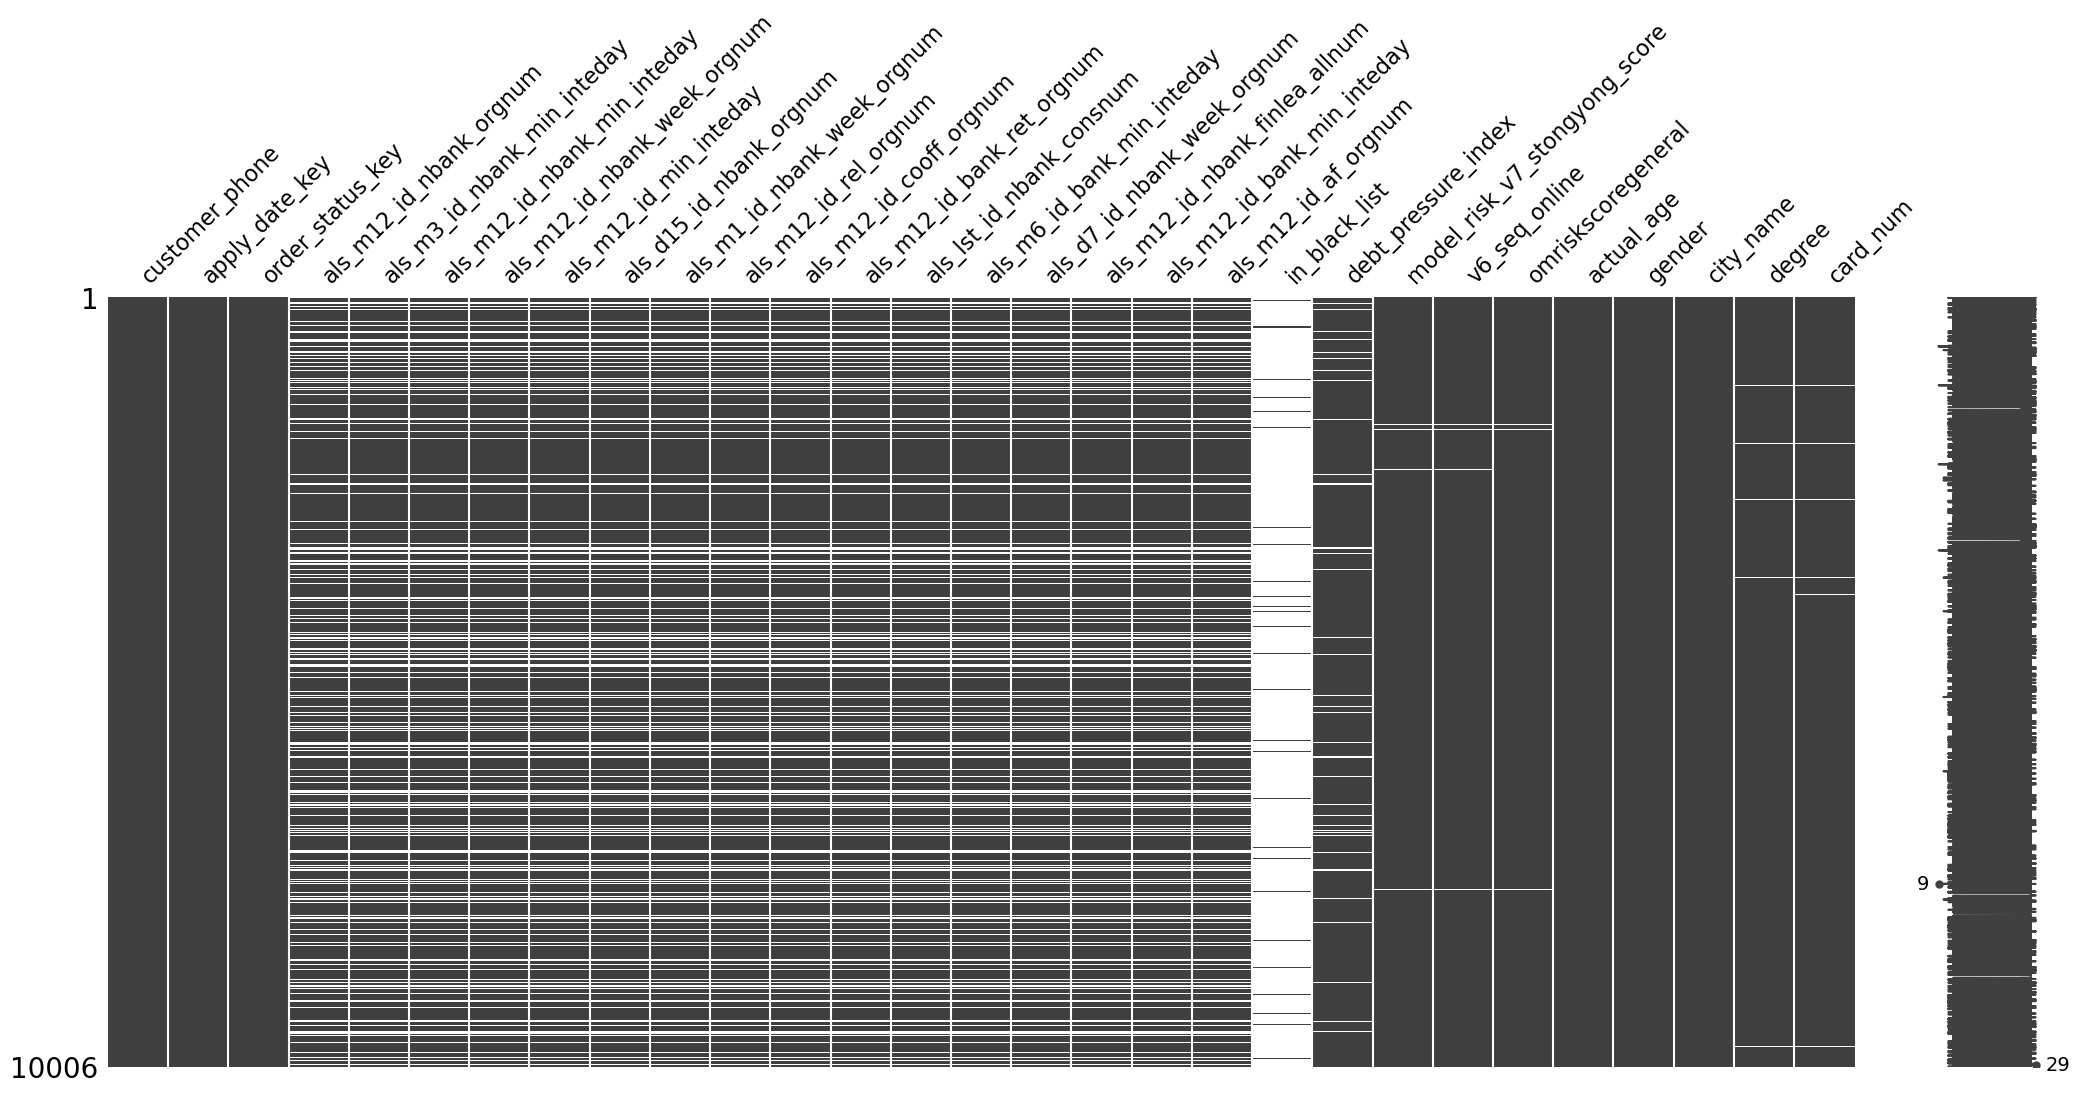

In [3]:
msno.matrix(data)

<AxesSubplot:>

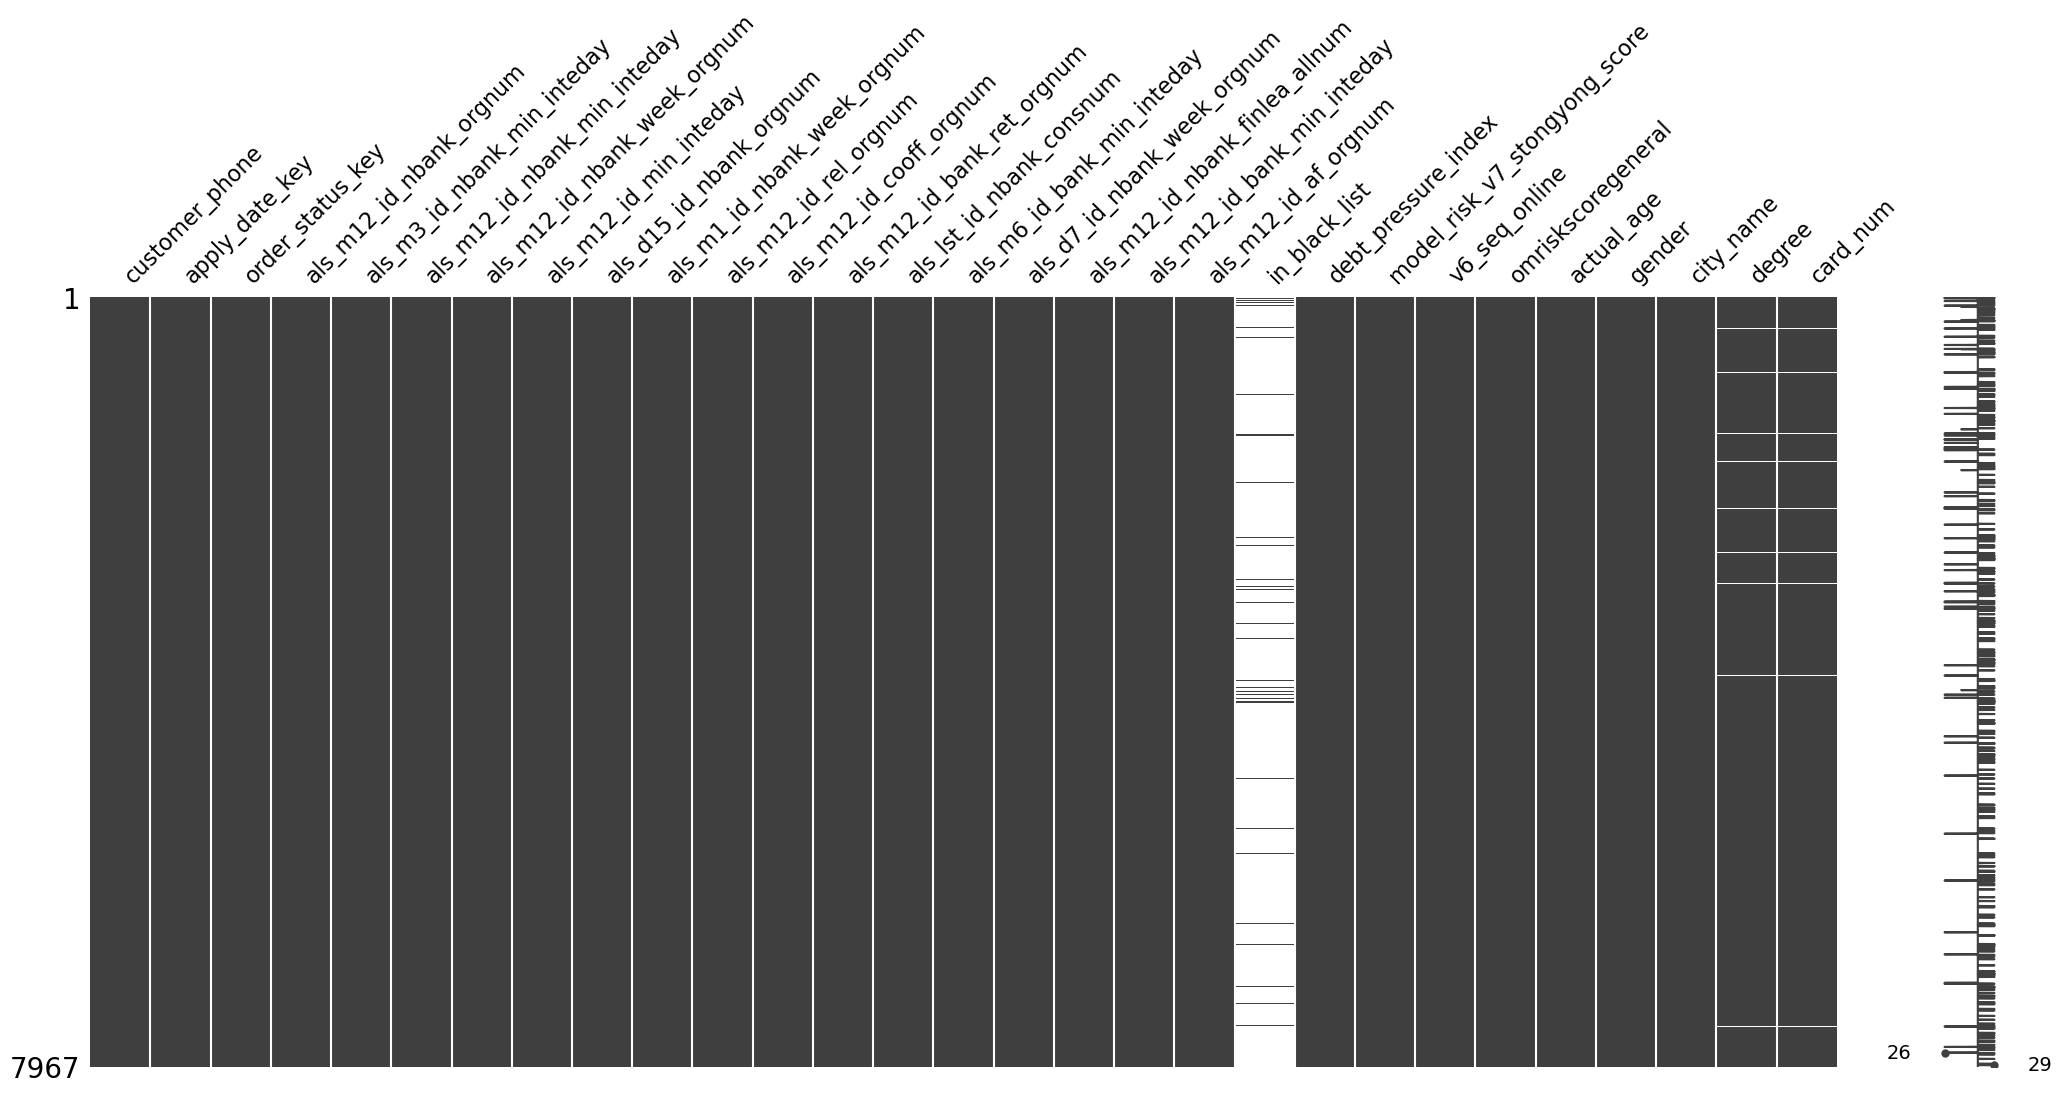

In [4]:
msno.matrix(data.dropna(subset=['als_m12_id_nbank_orgnum', 'model_risk_v7_stongyong_score', 'v6_seq_online', 'omriskscoregeneral']))

In [5]:
data.describe()

,order_status_key,als_m12_id_nbank_orgnum,als_m3_id_nbank_min_inteday,als_m12_id_nbank_min_inteday,als_m12_id_nbank_week_orgnum,als_m12_id_min_inteday,als_d15_id_nbank_orgnum,als_m1_id_nbank_week_orgnum,als_m12_id_rel_orgnum,als_m12_id_cooff_orgnum,als_m12_id_bank_ret_orgnum,als_lst_id_nbank_consnum,als_m6_id_bank_min_inteday,als_d7_id_nbank_week_orgnum,als_m12_id_nbank_finlea_allnum,als_m12_id_bank_min_inteday,als_m12_id_af_orgnum,debt_pressure_index,model_risk_v7_stongyong_score,v6_seq_online,omriskscoregeneral,actual_age
count,10006.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,9593.000000,9980.000000,9980.000000,9974.000000,10006.000000
mean,3.040576,5.541896,-5723.863807,-3045.533517,-1260.901576,-1597.844797,0.682841,-5922.014507,2.076038,0.194097,0.247499,1.054152,-6739.269510,-8255.713857,0.101176,-4996.271011,0.120935,26.665381,41.698597,36.266834,675.612593,36.749151
std,1.116212,7.935678,4950.530443,4619.382986,3322.697016,3688.615174,1.706247,4914.319435,1.928223,0.578623,0.644135,0.821350,4696.371228,3794.042691,0.531809,5019.536620,0.424405,9.485623,18.801710,11.866320,100.684171,8.773150
min,2.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,0.000000,-9999.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,-9999.000000,0.000000,-9999.000000,0.000000,1.000000,3.000000,7.000000,301.000000,18.000000
25%,2.000000,1.000000,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,-9999.000000,1.000000,0.000000,0.000000,1.000000,-9999.000000,-9999.000000,0.000000,-9999.000000,0.000000,21.000000,27.000000,28.000000,607.000000,30.000000
50%,3.000000,2.000000,-9999.000000,0.000000,1.000000,0.000000,0.000000,-9999.000000,2.000000,0.000000,0.000000,1.000000,-9999.000000,-9999.000000,0.000000,-9999.000000,0.000000,25.000000,40.000000,35.000000,676.000000,35.000000
75%,3.000000,6.000000,0.000000,5.000000,2.000000,8.000000,1.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,-9999.000000,0.000000,10.000000,0.000000,31.000000,56.000000,43.000000,746.000000,43.000000
max,6.000000,63.000000,86.000000,355.000000,37.000000,353.000000,25.000000,26.000000,13.000000,8.000000,6.000000,18.000000,170.000000,13.000000,14.000000,353.000000,8.000000,98.000000,92.000000,81.000000,900.000000,62.000000


根据多头（'als_m12_id_nbank_orgnum'）为空筛掉2000多个用户，这些用户的核卡率接近38%，属于优质客群，暂时不对这个客群建模。另外根据腾讯反欺诈，尚为综合信用评估去掉30多个空值的用户

In [6]:
data = data.dropna(subset=['als_m12_id_nbank_orgnum', 'model_risk_v7_stongyong_score', 'v6_seq_online', 'omriskscoregeneral'])

In [7]:
duplicates = data[data.duplicated(['customer_phone', 'apply_date_key'])].sort_values(['customer_phone'])['customer_phone'].tolist()
remove_duplicates = data[data['customer_phone'].isin(duplicates)].query('order_status_key != 6')
data = data[~data['customer_phone'].isin(duplicates)]
data = pd.concat([data, remove_duplicates])

根据之前的第三方数据的分析结果，百融近12个月非银机构的申请机构数能够有效划分客群，当设置阈值为8时，能够去除20%的被拒客户，同时召回率在99% (见/sda/share/notebooks/huweipeng/长安银行第三方数据检验.ipynb), 同时黑名单(in_black_list)也可以在接近不牺牲核卡用户的情况下，去掉大约3.5%的被拒用户。 因此先使用这两个特征做硬过滤后，再对剩下的特征做进一步探索

In [8]:
total_records = data.shape[0]
print(f'data has {data.shape[0]} records')
data = data.query('als_m12_id_nbank_orgnum <= 8')
records_left = data.shape[0]
print(f'{total_records - records_left} records are dropped')
data = data.query('in_black_list != True')
records_left2 = data.shape[0]
print(f'{records_left - records_left2} records are dropped')
print(f'data has {data.shape[0]} records remained')

data has 7936 records
1523 records are dropped
200 records are dropped
data has 6213 records remained


In [9]:
data = data.drop(columns='in_black_list')

In [10]:
data['order_status_key'] = data['order_status_key'].map({2:1}).fillna(0)
data['order_status_key'].value_counts()

0.0    4174
1.0    2039
Name: order_status_key, dtype: int64

In [11]:
print(*data.columns, sep=", ")

customer_phone, apply_date_key, order_status_key, als_m12_id_nbank_orgnum, als_m3_id_nbank_min_inteday, als_m12_id_nbank_min_inteday, als_m12_id_nbank_week_orgnum, als_m12_id_min_inteday, als_d15_id_nbank_orgnum, als_m1_id_nbank_week_orgnum, als_m12_id_rel_orgnum, als_m12_id_cooff_orgnum, als_m12_id_bank_ret_orgnum, als_lst_id_nbank_consnum, als_m6_id_bank_min_inteday, als_d7_id_nbank_week_orgnum, als_m12_id_nbank_finlea_allnum, als_m12_id_bank_min_inteday, als_m12_id_af_orgnum, debt_pressure_index, model_risk_v7_stongyong_score, v6_seq_online, omriskscoregeneral, actual_age, gender, city_name, degree, card_num


In [13]:
def calc_iv(matrix, feature, target, pr=False):
    df = matrix.copy()
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Distribution Good'] = (data['Good'] + 1) / data['Good'].sum()
    data['Distribution Bad'] = (data['Bad'] + 1) / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    data['IV'] = (data['Distribution Good'] - data['Distribution Bad']) * data['WoE']

    if pr:
        print(data.sort_values('Value'))
        print('IV = ', round(data['IV'].sum(), 6))

    return round(data['IV'].sum(), 6)

In [21]:
def binning(series):
    percentiles = list(range(0, 101, 10))
    val = np.percentile(series, percentiles).tolist()
    if min(series) >= 0:
        bins = list(sorted(set([min(val) - 1] + val)))
    else:
        bins = list(sorted(set([-10000, -9999] + [min(val) - 1] + val)))
        
    series_bin = pd.cut(series, bins, labels=list(range(len(bins) - 1))).astype("int")
    return series_bin
    
data_bin = data.copy()
data_bin.loc[:, 'als_m12_id_nbank_orgnum':'als_m12_id_af_orgnum'] = data_bin.loc[:, 'als_m12_id_nbank_orgnum':'als_m12_id_af_orgnum'].apply(binning)

data_bin.loc[:, 'debt_pressure_index':'omriskscoregeneral'] = \
    MinMaxScaler().fit_transform(data_bin.loc[:, 'debt_pressure_index':'omriskscoregeneral'])
data_bin.loc[:, 'debt_pressure_index':'omriskscoregeneral']  = \
    data_bin.loc[:, 'debt_pressure_index':'omriskscoregeneral'] .apply(binning)

feature_iv = []
for f in data_bin.iloc[:, 3:].columns:
    feature_iv.append([f, calc_iv(data_bin, f, 'order_status_key', False)])
feature_iv = pd.DataFrame(feature_iv, columns=['feature', 'iv']).sort_values('iv', ascending=False)

X = add_constant(data_bin.loc[:, 'als_m12_id_nbank_orgnum':'omriskscoregeneral'])
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns).rename('vif')

feature_iv = feature_iv.merge(vif, left_on='feature', right_index=True)

In [22]:
feature_iv.reset_index(drop=True)

,feature,iv,vif
0,model_risk_v7_stongyong_score,0.560879,2.671904
1,omriskscoregeneral,0.479658,2.828866
2,als_m12_id_nbank_orgnum,0.427727,3.387354
3,als_m12_id_nbank_min_inteday,0.418542,1.478071
4,als_m12_id_min_inteday,0.371059,1.490072
5,als_m3_id_nbank_min_inteday,0.358849,1.590293
6,debt_pressure_index,0.282633,1.394538
7,v6_seq_online,0.224494,1.447703
8,als_m12_id_nbank_week_orgnum,0.192185,2.663092
9,als_lst_id_nbank_consnum,0.149107,1.668145


In [24]:
age = data_bin[['customer_phone', 'actual_age']].dropna(subset=['actual_age'])
age['actual_age'] = age[['actual_age']].apply(binning)

In [25]:
data_bin.drop('actual_age', axis=1, inplace=True)
data_bin = data_bin.merge(age, on='customer_phone', how='left')
data_bin['actual_age'] = data_bin['actual_age'].fillna(-1)
data_bin['actual_age'].value_counts()

2     754
4     693
1     682
7     640
8     618
5     606
9     605
6     582
10    566
3     560
0      11
Name: actual_age, dtype: int64

In [16]:
calc_iv(data_bin, 'actual_age', 'order_status_key', True)

      Variable  Value  All  Good  Bad  Distribution Good  Distribution Bad  \
8   actual_age      0   11     0   11           0.000490          0.002807   
9   actual_age      1  682   116  566           0.057297          0.132632   
6   actual_age      2  754   223  531           0.109696          0.124444   
7   actual_age      3  560   165  395           0.081293          0.092632   
5   actual_age      4  693   258  435           0.126836          0.101988   
4   actual_age      5  606   193  413           0.095005          0.096842   
3   actual_age      6  582   217  365           0.106758          0.085614   
0   actual_age      7  640   245  395           0.120470          0.092632   
10  actual_age      8  618   229  389           0.112635          0.091228   
2   actual_age      9  605   217  388           0.106758          0.090994   
1   actual_age     10  566   179  387           0.088149          0.090760   

         WoE        IV  
8  -1.746052  0.004046  
9  -0.839331 

0.09516

In [17]:
data_bin['gender'] = data_bin['gender'].fillna("u")
calc_iv(data_bin, 'gender', 'order_status_key', True)

  Variable   Value   All  Good   Bad  Distribution Good  Distribution Bad  \
0   gender  female  2247   941  1306           0.461312          0.305731   
1   gender    male  4070  1101  2969           0.539667          0.694737   

        WoE        IV  
0  0.411370  0.064002  
1 -0.252581  0.039168  
IV =  0.103169


0.103169

In [18]:
major_city = ['u', '西安市', '宝鸡市', '咸阳市', '渭南市', '延安市',' 铜川市', '天水市']
data_bin.loc[data_bin['city_name'].isin(major_city), 'city_name2'] = data_bin['city_name']
data_bin['city_name2'] = data_bin['city_name2'].fillna('rare')

In [19]:
data_bin['city_name2'].value_counts()

u       1785
西安市     1141
rare     977
宝鸡市      838
咸阳市      673
渭南市      520
延安市      314
天水市       69
Name: city_name2, dtype: int64

In [20]:
calc_iv(data_bin, 'city_name2', 'order_status_key', True)

     Variable Value   All  Good   Bad  Distribution Good  Distribution Bad  \
2  city_name2  rare   977   302   675           0.148384          0.158129   
3  city_name2     u  1785   560  1225           0.274731          0.286784   
7  city_name2   咸阳市   673   190   483           0.093536          0.113216   
5  city_name2   天水市    69    13    56           0.006856          0.013333   
4  city_name2   宝鸡市   838   332   506           0.163075          0.118596   
1  city_name2   延安市   314    95   219           0.047013          0.051462   
6  city_name2   渭南市   520   179   341           0.088149          0.080000   
0  city_name2   西安市  1141   371   770           0.182174          0.180351   

        WoE        IV  
2 -0.063606  0.000620  
3 -0.042937  0.000518  
7 -0.190957  0.003758  
5 -0.665140  0.004308  
4  0.318486  0.014166  
1 -0.090425  0.000402  
6  0.097000  0.000790  
0  0.010060  0.000018  
IV =  0.024581


0.024581

In [21]:
data['degree'] = data['degree'].fillna("NONE")
calc_iv(data, 'degree', 'order_status_key', True)

  Variable     Value   All  Good   Bad  Distribution Good  Distribution Bad  \
3   degree      NONE    47     2    45           0.001471          0.011021   
1   degree      大学专科  4327  1419  2908           0.696420          0.696933   
0   degree      大学本科   806   360   446           0.177048          0.107092   
4   degree  硕士（含）及以上    43    19    24           0.009809          0.005989   
2   degree     高中及以下   990   239   751           0.117705          0.180163   

        WoE            IV  
3 -2.013614  1.922859e-02  
1 -0.000737  3.786091e-07  
0  0.502735  3.516933e-02  
4  0.493272  1.883939e-03  
2 -0.425682  2.658732e-02  
IV =  0.08287


0.08287

In [22]:
data['card_num'] = data['card_num'].fillna('NONE')
calc_iv(data.query('card_num != "NONE"'), 'card_num', 'order_status_key', True)

   Variable  Value   All  Good   Bad  Distribution Good  Distribution Bad  \
1  card_num     1张  1772   588  1184           0.289151          0.287134   
3  card_num     2张  1538   623   915           0.306333          0.221953   
0  card_num     3张   860   312   548           0.153657          0.133026   
2  card_num  4张及以上   804   282   522           0.138930          0.126726   
4  card_num   无信用卡  1190   232   958           0.114384          0.232372   

        WoE        IV  
1  0.007001  0.000014  
3  0.322207  0.027188  
0  0.144177  0.002975  
2  0.091938  0.001122  
4 -0.708780  0.083628  
IV =  0.114926


0.114926

In [23]:
data.query('degree == "NONE" | card_num == "NONE"').shape

(49, 36)

card_num和学历为NONE是因为问卷下线导致的，在生产环境中也可能出现这种情况。模型要兼容这种情况发生

In [26]:
use_features = feature_iv.query('iv > 0.1')['feature'].tolist() + ['in_black_list', 'actual_age', 'gender', 'degree', 'card_num']
pickle.dump(use_features, open(config.USE_FEATURES, "wb"))

## 总结
### 初步使用以下特征
'model_risk_v7_stongyong_score',  
'omriskscoregeneral',  
'als_m12_id_nbank_orgnum',  
'als_m12_id_nbank_min_inteday',  
'als_m12_id_min_inteday',  
'als_m3_id_nbank_min_inteday',  
'debt_pressure_index',  
'v6_seq_online',  
'als_m12_id_nbank_week_orgnum',  
'als_lst_id_nbank_consnum',  
'als_d15_id_nbank_orgnum',  
'als_m1_id_nbank_week_orgnum',  
'in_black_list',  
'actual_age',  
'gender',  
'degree',  
'card_num'  

### 预处理方式
- 去除重复记录
- order_status_key映射为0和1
- 去除als_m12_id_nbank_orgnum > 8 或者在百融黑名单中的客户
- 去除als_m12_id_nbank_orgnum, model_risk_v7_stongyong_score, v6_seq_online, omriskscoregeneral为空的客户
- gender为空的NONE来处理
- age为空的用-1来填充

below you can do what the fuck you want

In [75]:
data.describe()

,order_status_key,als_m12_id_nbank_orgnum,als_m3_id_nbank_max_inteday,als_lst_id_nbank_inteday,als_m12_id_rel_orgnum,als_m6_id_nbank_max_inteday,als_m3_id_max_inteday,als_m12_id_caoff_orgnum,als_m12_id_cooff_orgnum,als_m12_id_nbank_max_inteday,als_m12_id_nbank_night_orgnum,als_m12_id_bank_ret_orgnum,als_lst_id_nbank_consnum,als_m12_id_min_inteday,als_m12_id_max_inteday,als_m12_id_nbank_finlea_allnum,als_m12_id_bank_week_orgnum,als_m3_id_bank_max_inteday,als_m6_id_bank_max_inteday,als_m12_id_af_allnum,als_m1_id_nbank_night_allnum,als_d7_id_nbank_week_allnum,als_m6_id_min_inteday,als_m12_id_bank_max_inteday,als_m12_id_nbank_min_inteday,debt_pressure_index,model_risk_v7_stongyong_score,v6_seq_online,omriskscoregeneral,actual_age
count,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000,6213.000000
mean,0.328183,2.288427,8.423789,76.563496,1.521165,22.204732,11.046998,0.142765,0.047964,56.474650,0.360052,0.093996,0.945759,22.382585,76.600676,0.015773,0.385643,3.500241,13.961049,0.071624,0.048125,0.029937,10.215033,46.719942,19.515693,25.219218,39.123129,34.877354,688.125543,36.316111
std,0.469590,2.047061,15.904441,91.415472,1.381185,32.375358,17.337862,0.401295,0.223285,67.374184,0.662388,0.326227,0.617767,50.748213,69.567707,0.153545,0.693313,11.443900,31.534445,0.334997,0.246224,0.203175,24.632726,72.514890,47.490633,5.896857,17.489804,11.306140,90.814418,8.436795
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,7.000000,336.000000,18.000000
25%,0.000000,1.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,25.000000,27.000000,623.000000,30.000000
50%,0.000000,2.000000,0.000000,38.000000,1.000000,0.000000,0.000000,0.000000,0.000000,36.000000,0.000000,0.000000,1.000000,0.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,38.000000,34.000000,685.000000,35.000000
75%,1.000000,3.000000,12.000000,113.000000,2.000000,41.000000,20.000000,0.000000,0.000000,96.000000,1.000000,0.000000,1.000000,16.000000,116.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,87.000000,11.000000,29.000000,52.000000,42.000000,752.000000,42.000000
max,1.000000,8.000000,86.000000,359.000000,11.000000,175.000000,86.000000,3.000000,2.000000,355.000000,4.000000,4.000000,9.000000,353.000000,353.000000,4.000000,6.000000,82.000000,172.000000,5.000000,4.000000,4.000000,169.000000,353.000000,355.000000,48.000000,89.000000,81.000000,900.000000,61.000000


In [102]:
discretizer = KBinsDiscretizer(strategy="quantile", encode="ordinal", n_bins=10)

In [103]:
set(discretizer.fit_transform(data[['als_m12_id_nbank_orgnum']])[:, 0])

/sda/software/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}

In [99]:
data_bin['als_m12_id_nbank_orgnum'].unique()

array([2, 1, 0, 6, 4, 3, 5])